In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras
from keras.layers import Dense, Dropout

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score


# Get Data

make sampling even

1. reduce the dataset (253680,) by sampling a smaller size (50736 rows), and using the binary dataset (70692 rows)
2. min-max scale the features to account for different ranges in data like BMI
3. add an intercept bias term to features
4. split into training/test data

**Note**: diabetes_012 has three classes
- 0: no diabetes or only during pregnancy
- 1: prediabetes
- 2: diabetes

In [178]:
df = pd.read_csv('../archive/diabetes_012_health_indicators_BRFSS2015.csv')

df["Diabetes_012"].value_counts()

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

In [179]:
# columns should be type int -- none are float or categorical
df = df.astype(int)
print(df.shape)

# reduce dataset by sampling proportionally
df_unbalanced3 = df.sample(frac=0.1, random_state=1)
print(df_unbalanced3.shape)

# reduce dataset by sampling evenly - 3 classes, prediabetes only has 4631 samples and is a limiting factor
df_balanced3 = df.groupby('Diabetes_012').apply(lambda x: x.sample(4631, random_state=1)).reset_index(drop=True)
print(df_balanced3.shape)

# this dataset is already balanced - 2 classes. we can sample it down to match the others a bit more though
df_balanced2 = pd.read_csv('../archive/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df_balanced2 = df_balanced2.sample(frac=0.3, random_state=1)
print(df_balanced2.shape)

(253680, 22)
(25368, 22)
(13893, 22)
(21208, 22)


/var/folders/jh/22zl01dx76l3c98lkgd5cn440000gp/T/ipykernel_80377/3719742648.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced3 = df.groupby('Diabetes_012').apply(lambda x: x.sample(4631, random_state=1)).reset_index(drop=True)


In [180]:
def getTrainTestData(df, y_label, test_size=0.25):
    """
    Splits the data into train and test sets.
    """

    # Split the data into features and target
    X = df.drop(y_label, axis=1)
    y = df[y_label].to_numpy()

    # min max scaling, rounded to 3 decimal places
    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X).round(3)
    # Add a new column filled with ones -- for intercept/bias term
    X_scale = np.hstack((X_scale,np.ones([X_scale.shape[0],1], X_scale.dtype)))

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_size, random_state=1)

    return X_train, X_test, y_train, y_test

In [181]:
# split into different train test sets
X_train_unb3, X_test_unb3, y_train_unb3, y_test_unb3 = getTrainTestData(df_unbalanced3, 'Diabetes_012')
X_train_bal3, X_test_bal3, y_train_bal3, y_test_bal3 = getTrainTestData(df_balanced3, 'Diabetes_012')
X_train_bal2, X_test_bal2, y_train_bal2, y_test_bal2 = getTrainTestData(df_balanced2, 'Diabetes_binary')
X_train_big, X_test_big, y_train_big, y_test_big = getTrainTestData(df, 'Diabetes_012')

# Exploratory DA

Just seeing how features relate to each of the three classes, idk, playing around a bit

Diabetes_012
0    213703
2     35346
1      4631
Name: count, dtype: int64


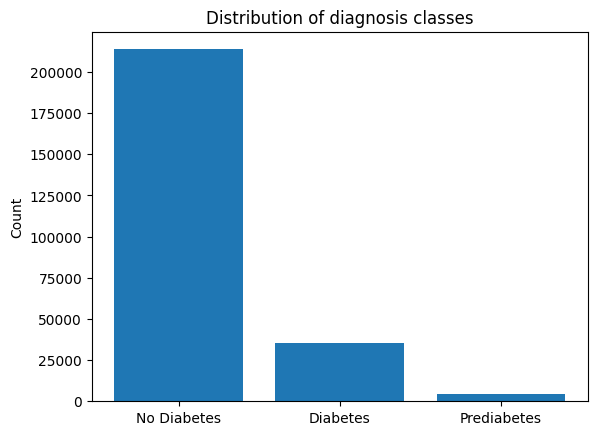

In [182]:
# the distribution of classes. As you can see, the dataset is not balanced
counts = df['Diabetes_012'].value_counts()
print(counts)

classes = ['No Diabetes', 'Prediabetes', 'Diabetes']
plt.bar(counts.index.map(lambda x: classes[x]), counts.values)

# df['Diabetes_012'].value_counts().plot(kind='bar')
plt.title('Distribution of diagnosis classes')
plt.ylabel('Count')
plt.savefig('diabetes_distribution.png')
plt.show()


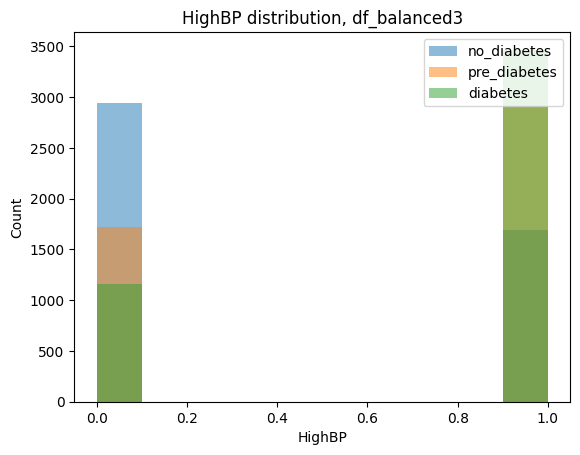

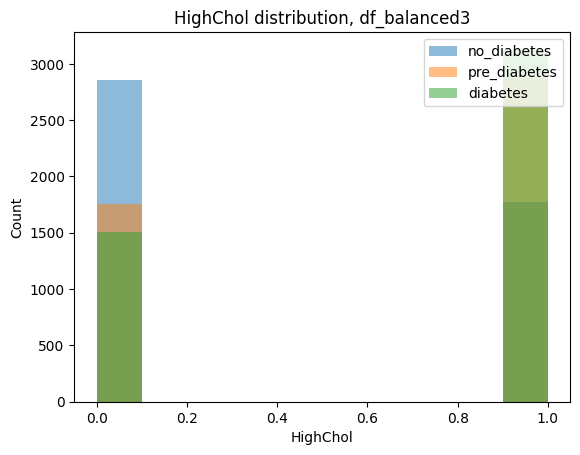

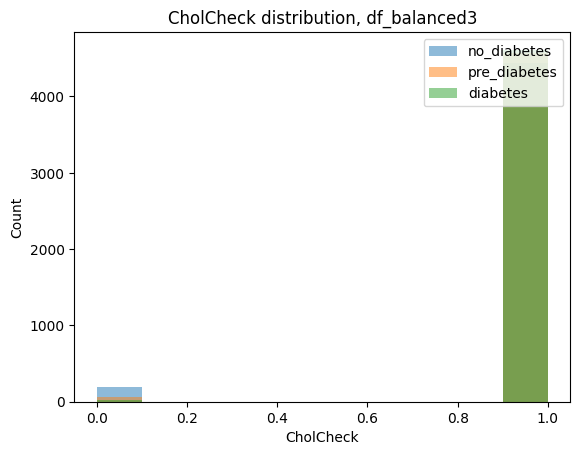

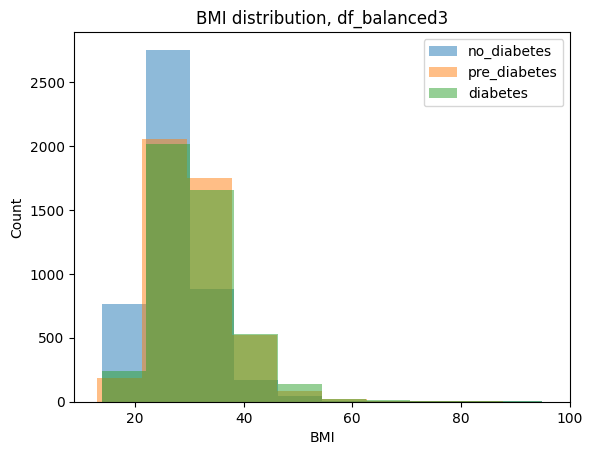

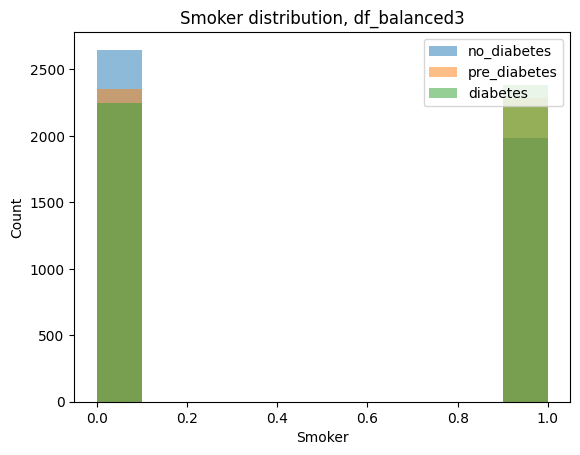

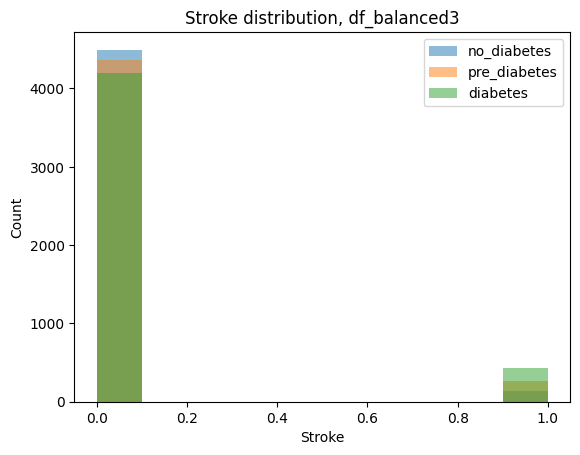

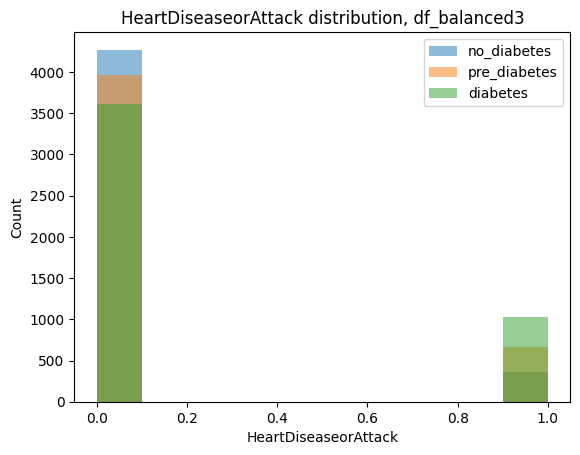

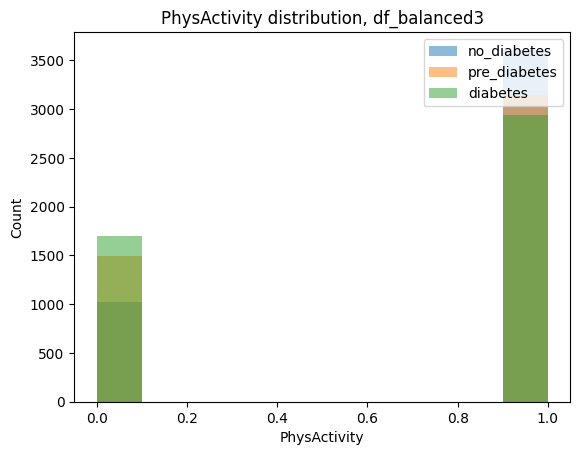

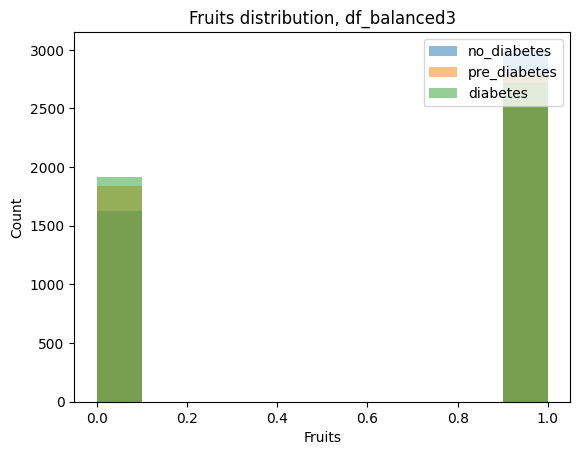

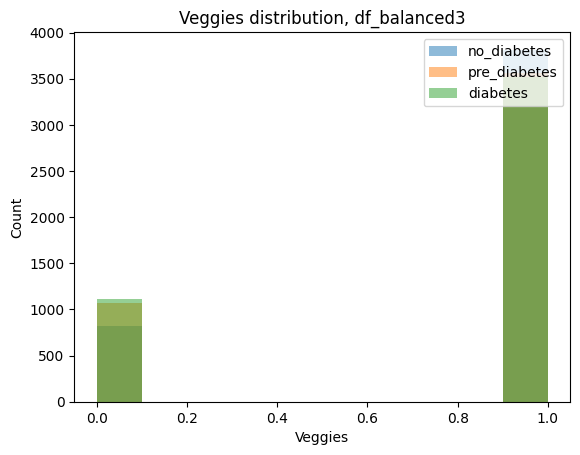

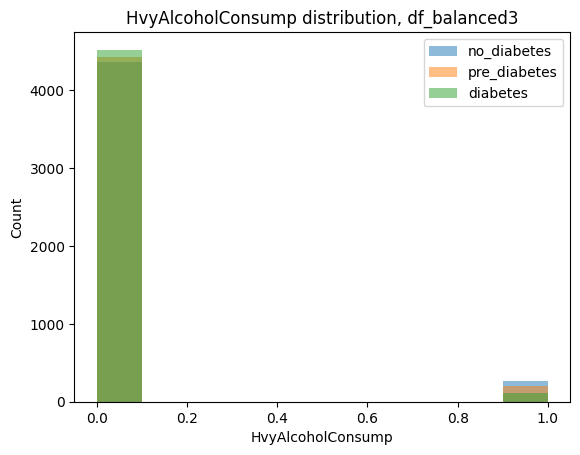

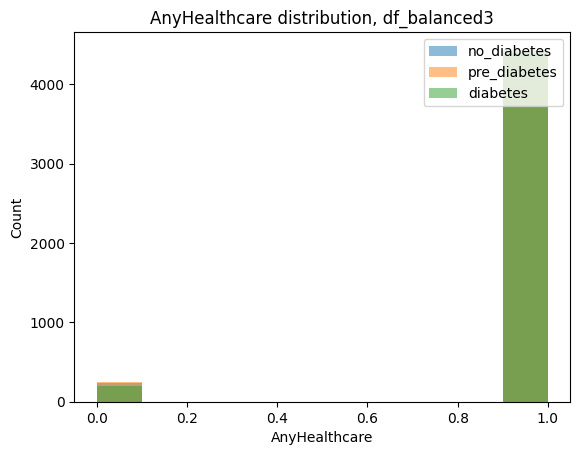

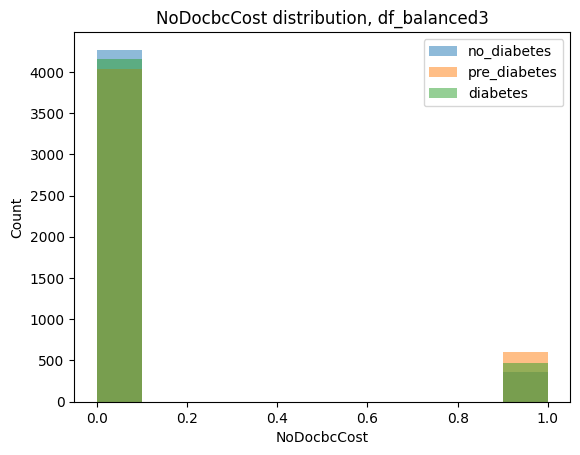

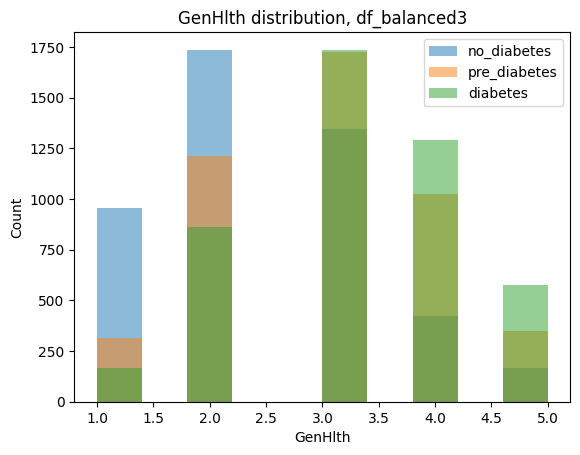

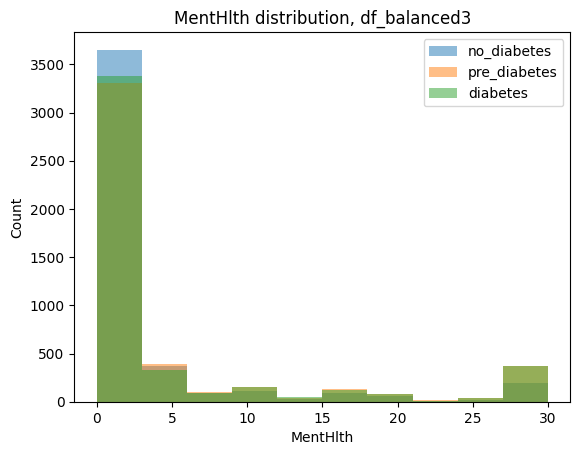

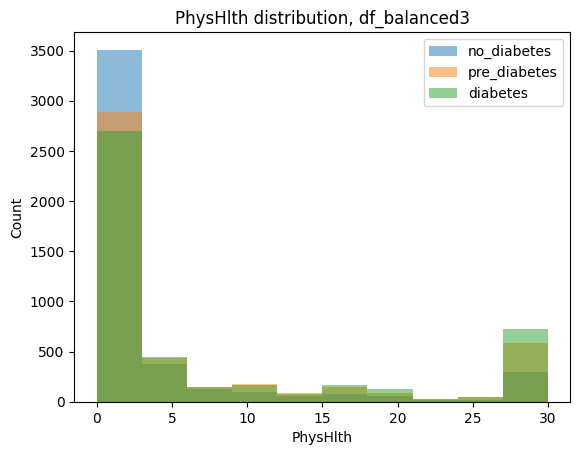

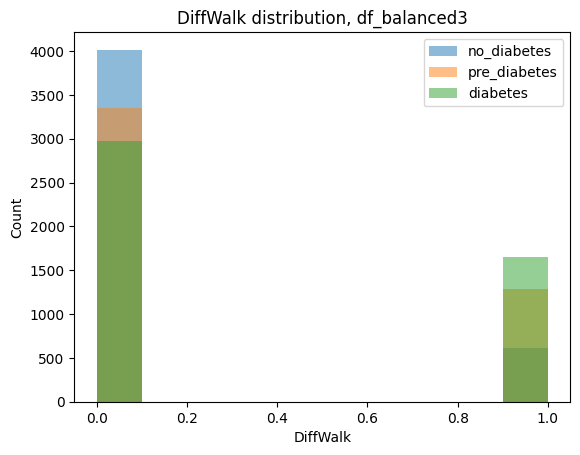

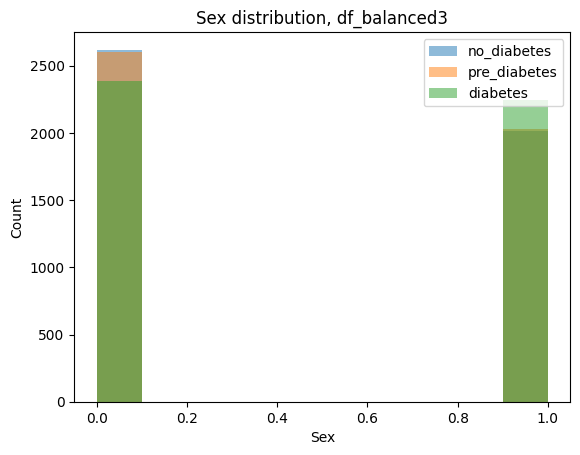

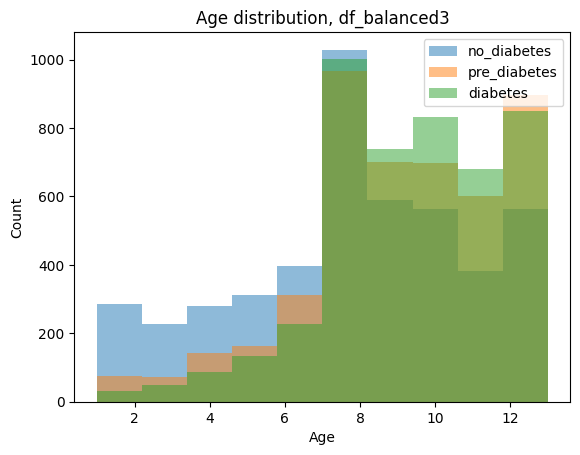

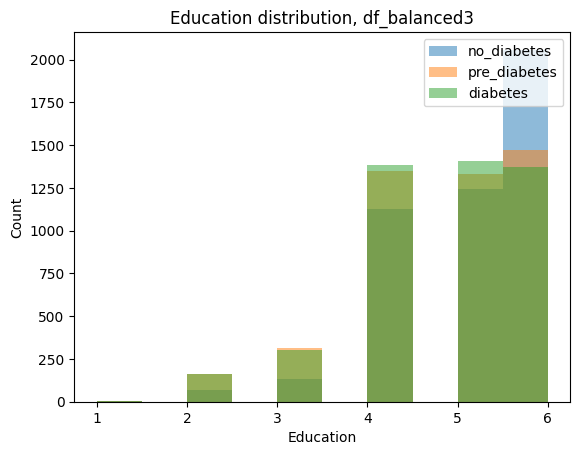

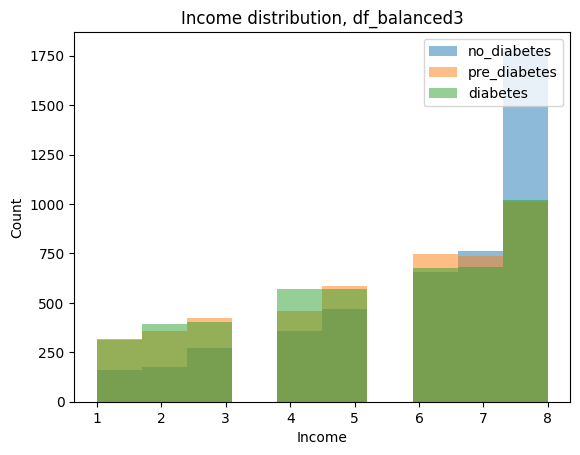

In [183]:
feats = df.columns[1:]

# separating by class
# we are using the balanced dataset for better visualization
no_diabetes = df_balanced3.loc[df_balanced3['Diabetes_012'] == 0, :]
pre_diabetes = df_balanced3.loc[df_balanced3['Diabetes_012'] == 1, :]
diabetes = df_balanced3.loc[df_balanced3['Diabetes_012'] == 2, :]

for feat in feats:
    
    plt.hist(no_diabetes[feat], alpha=0.5, label='no_diabetes')
    plt.hist(pre_diabetes[feat], alpha=0.5, label='pre_diabetes')
    plt.hist(diabetes[feat], alpha=0.5, label='diabetes')
    plt.legend(loc='upper right')
    plt.title(f'{feat} distribution, df_balanced3')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.savefig('distribution_'+ feat + '.png')
    plt.show()

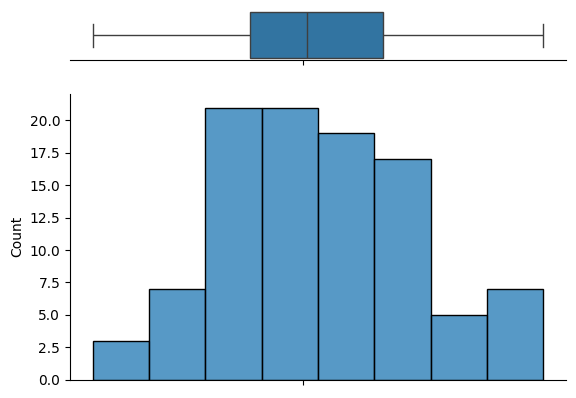

In [184]:
# test on randomly generated data, how to layer a boxplot over a histogram
x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box, vert=False)
sns.histplot(x, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

# MLP

## sklearn

- sklearn is easy to setup, generally.
- uses LOG LOSS on ACCURACY

- ~45 seconds to fit: 300 iterations, 1 hidden layer size 100

ADAM: df_unb3
- 0.848 , hidden = (15,)
- 0.848, hidden = (20), batch_size=50 --> 20 seconds to train also

WITH BALANCED DATASET: 2 classes
- .74

### UNB3

In [185]:
# plot the confusion matrix
def plot_confusion_matrix(y_actual, y_pred, labels, title='Confusion Matrix', save_path=None):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    if (save_path != None):
        plt.savefig(save_path)
    plt.show()
    
    print(f'accuracy: {accuracy_score(y_actual, y_pred)}')
    diabetes_label = 1 if len(cm) == 2 else 2
    print(f'recall: {recall_score(y_actual, y_pred, average=None)}')

[[0.42605626 0.03707886 0.53686489]]
0.8453169347209082


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


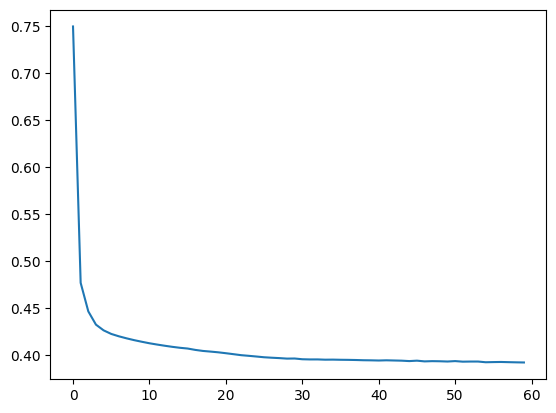

In [186]:
# test the small, unbalanced dataset
mlp_unb3 = MLPClassifier(
    random_state=1, 
    max_iter=60,
    batch_size=50,
    hidden_layer_sizes=(5,10),
    learning_rate='invscaling',
                    ).fit(X_train_unb3, y_train_unb3)

print(mlp_unb3.predict_proba(X_test_unb3[:1]))
print(mlp_unb3.score(X_test_unb3, y_test_unb3))

# plot the loss curve
plt.plot(mlp_unb3.loss_curve_)

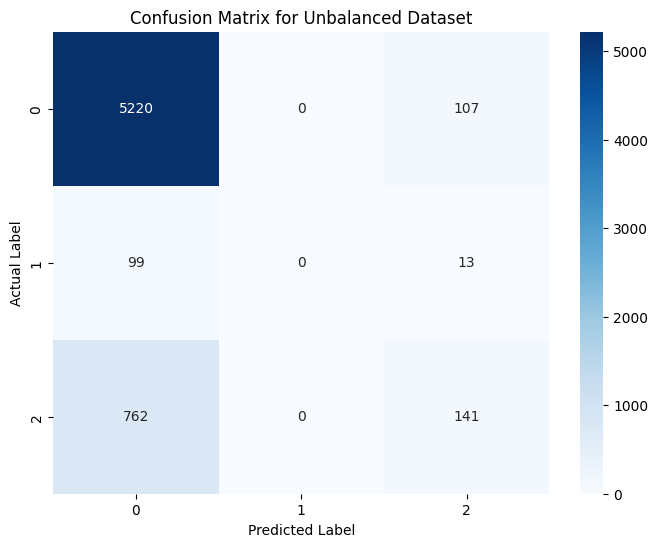

accuracy: 0.8453169347209082
recall: [0.97991365 0.         0.15614618]


In [187]:
plot_confusion_matrix(
    y_test_unb3, 
    mlp_unb3.predict(X_test_unb3), 
    [0,1,2], 
    title='Confusion Matrix for Unbalanced Dataset', 
    save_path='confusion_matrix_unbalanced.png'
    )

### BAL3

[[0.17952427 0.32708888 0.49338685]]
0.5201496833621186


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


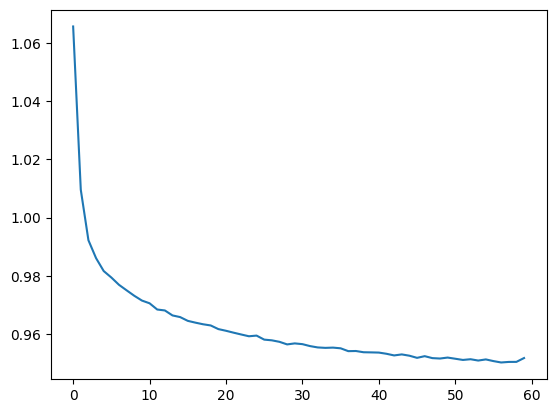

In [188]:
# test the balanced dataset
mlp_bal3 = MLPClassifier(
    random_state=1, 
    max_iter=60,
    batch_size=50,
    hidden_layer_sizes=(8),
    learning_rate='invscaling',
                    ).fit(X_train_bal3, y_train_bal3)

print(mlp_bal3.predict_proba(X_test_bal3[:1]))
print(mlp_bal3.score(X_test_bal3, y_test_bal3))

# plot the loss curve
plt.plot(mlp_bal3.loss_curve_)

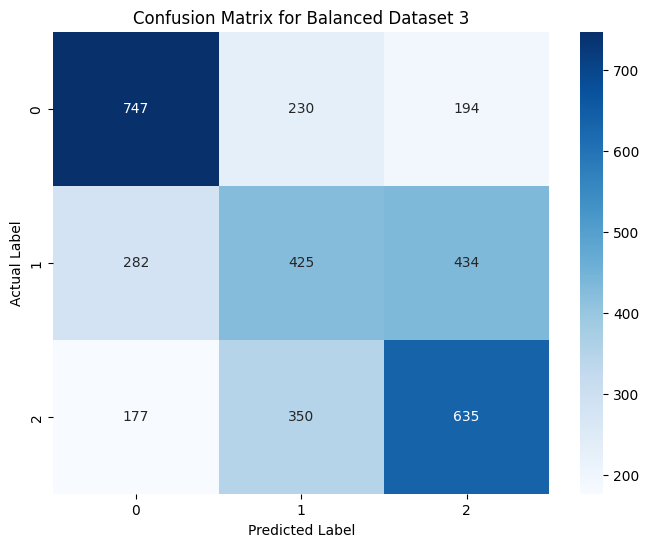

accuracy: 0.5201496833621186
recall: [0.63791631 0.37248028 0.5464716 ]


In [189]:
plot_confusion_matrix(
    y_test_bal3, 
    mlp_bal3.predict(X_test_bal3), 
    [0,1,2], 
    title='Confusion Matrix for Balanced Dataset 3', 
    save_path='confusion_matrix_balanced3.png'
    )

### BAL2

[[0.5080501 0.4919499]]
0.7450018860807243


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


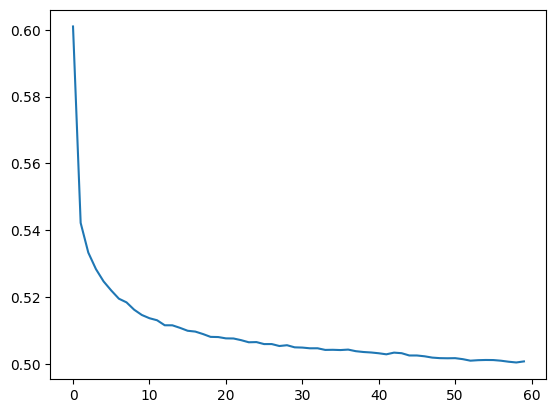

In [190]:
# test the balanced dataset
mlp_bal2 = MLPClassifier(
    random_state=1, 
    max_iter=60,
    batch_size=50,
    hidden_layer_sizes=(8),
    learning_rate='invscaling',
                    ).fit(X_train_bal2, y_train_bal2)

print(mlp_bal2.predict_proba(X_test_bal2[:1]))
print(mlp_bal2.score(X_test_bal2, y_test_bal2))

# plot the loss curve
plt.plot(mlp_bal2.loss_curve_)

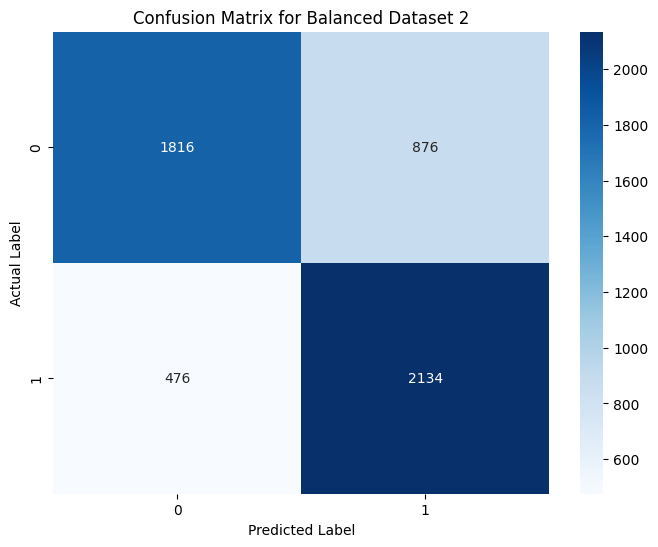

accuracy: 0.7450018860807243
recall: [0.67459138 0.81762452]


In [191]:
plot_confusion_matrix(
    y_test_bal2, 
    mlp_bal2.predict(X_test_bal2), 
    [0,1], 
    title='Confusion Matrix for Balanced Dataset 2', 
    save_path='confusion_matrix_balanced2.png'
    )

### I think i tried to do a grid search here. but it took a really long time lol.

In [192]:
# Define the parameter grid
'''

param_grid = {
    'hidden_layer_sizes': [(20,), (10,), (5,), (10, 5)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'batch_size': [50, 100]
}

# Instantiate the MLPClassifier
mlp = MLPClassifier(max_iter=100, random_state=1)

# Instantiate GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_bal3, y_train_bal3)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

'''

'\n\nparam_grid = {\n    \'hidden_layer_sizes\': [(20,), (10,), (5,), (10, 5)],\n    \'activation\': [\'relu\', \'tanh\'],\n    \'solver\': [\'adam\', \'lbfgs\', \'sgd\'],\n    \'alpha\': [0.0001, 0.001, 0.01],\n    \'learning_rate\': [\'constant\', \'adaptive\', \'invscaling\'],\n    \'batch_size\': [50, 100]\n}\n\n# Instantiate the MLPClassifier\nmlp = MLPClassifier(max_iter=100, random_state=1)\n\n# Instantiate GridSearchCV\ngrid_search = GridSearchCV(mlp, param_grid, cv=3, scoring=\'accuracy\')\n\n# Fit GridSearchCV\ngrid_search.fit(X_train_bal3, y_train_bal3)\n\n# Print the best parameters and score\nprint("Best parameters:", grid_search.best_params_)\nprint("Best score:", grid_search.best_score_)\n\n'

## keras

- better insign in the models
- better for larger data as well

we are also interested in optimizing RECALL as that is more important for this use case

### UNB3 dataset:

---
**Accuracy: 0.8488273024559021**

model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train_p, epochs=10, batch_size=32)

---

**Accuracy: 0.8508356809616089**

model = keras.Sequential([
    Dense(10, activation='relu', input_shape=(22,)),
    Dense(5, activation='relu', input_shape=(10,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)

---

**Accuracy: 0.8521759510040283**
model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_small, y_train_p, epochs=5, batch_size=32, verbose=1)

---

In [193]:
y_train_p = keras.utils.to_categorical(y_train_unb3, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_unb3, num_classes=3)

model_unb3 = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model_unb3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_unb3.fit(X_train_unb3, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model_unb3.evaluate(X_test_unb3, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.7772 - loss: 0.6201
Epoch 2/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8433 - loss: 0.4349
Epoch 3/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.8423 - loss: 0.4174
Epoch 4/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.8421 - loss: 0.4195
Epoch 5/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.8434 - loss: 0.4142
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8367 - loss: 0.4124


0.8390097618103027

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


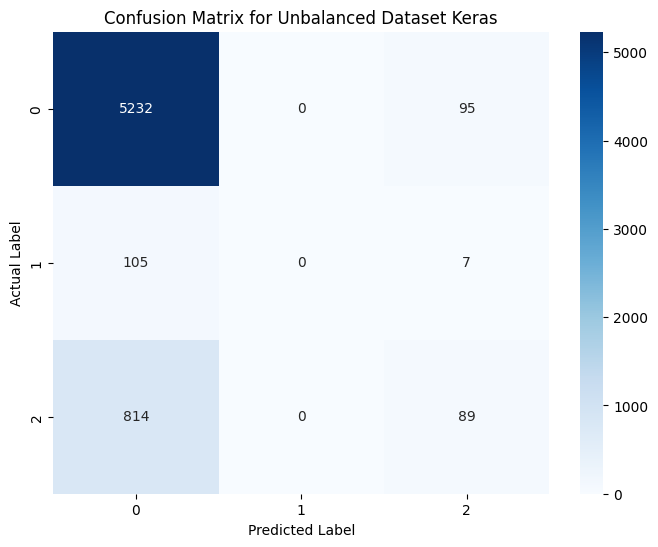

accuracy: 0.8390097760958688
recall: [0.98216632 0.         0.09856035]


In [194]:
y_prob = model_unb3.predict(X_test_unb3) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_unb3, 
                      y_classes, 
                      labels=[0, 1, 2], 
                      title='Confusion Matrix for Unbalanced Dataset Keras', 
                      save_path='confusion_matrix_keras_unbalanced.png')

## BAL3 dataset

**NOTE**

I tested optimizing for accuracy, and optimizing for recall (class 2) several times. but the results vary a decent amount tbh and usually end up between .60 and .65, either or. Generally, though, the higher the accuracy, the lower the recall.

---

**Accuracy: 0.5017271041870117**

model_bal3 = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model_bal3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

---

In [195]:
# trying to optimize for accuracy
y_train_p = keras.utils.to_categorical(y_train_bal3, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_bal3, num_classes=3)

model_bal3 = keras.Sequential([
    Dense(8, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model_bal3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_bal3.fit(X_train_bal3, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model_bal3.evaluate(X_test_bal3, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.4059 - loss: 0.6412
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.4732 - loss: 0.6026
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.4824 - loss: 0.5895
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.5037 - loss: 0.5816
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.4966 - loss: 0.5808
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.4943 - loss: 0.5765


0.49597007036209106

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


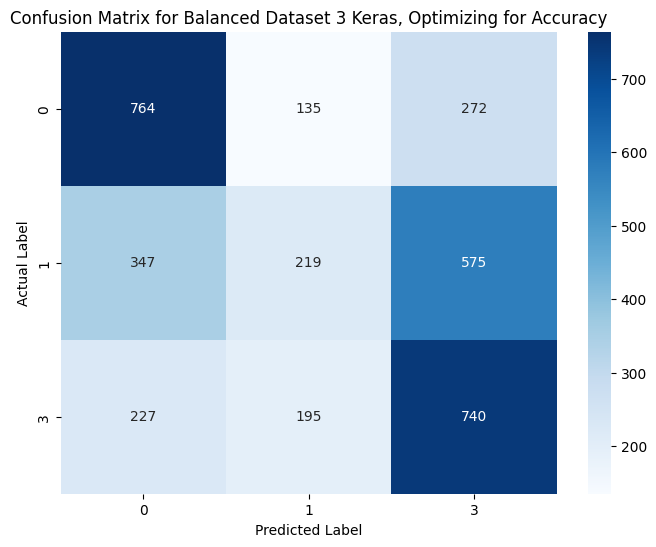

accuracy: 0.49597006332757626
recall: [0.65243382 0.1919369  0.63683305]


In [196]:
y_prob = model_bal3.predict(X_test_bal3) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_bal3, 
                      y_classes, 
                      labels=[0, 1, 3], 
                      title='Confusion Matrix for Balanced Dataset 3 Keras, Optimizing for Accuracy',
                      save_path='confusion_matrix_keras_balanced3_accuracy.png') 


In [197]:
# trying to optimize for recall class 2
y_train_p = keras.utils.to_categorical(y_train_bal3, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_bal3, num_classes=3)

model_bal3 = keras.Sequential([
    Dense(8, activation='relu', input_shape=(22,)),
    Dense(3, activation='softmax'),
])

model_bal3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[keras.metrics.Recall(class_id=2)])

model_bal3.fit(X_train_bal3, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model_bal3.evaluate(X_test_bal3, y_test_p)
accuracy

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 0.6525 - recall_13: 0.0000e+00
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.6074 - recall_13: 0.0061  
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.5865 - recall_13: 0.2076
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.5837 - recall_13: 0.2790
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.5792 - recall_13: 0.4440
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.5704 - recall_13: 0.4232


0.4182443916797638

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


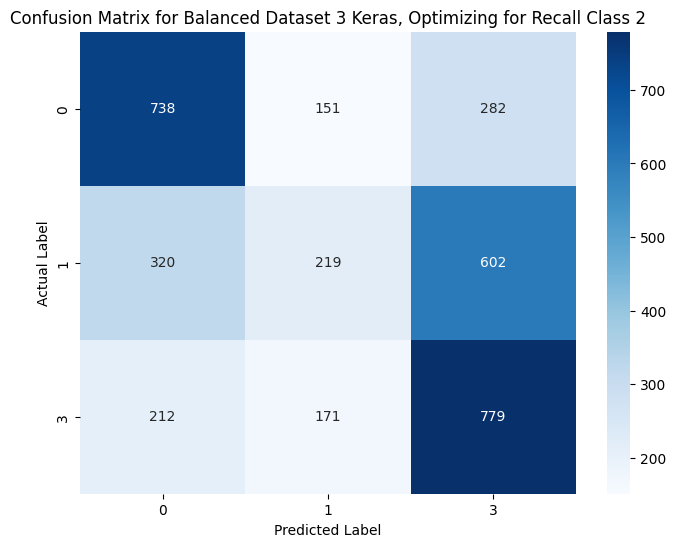

accuracy: 0.49971214738054115
recall: [0.63023057 0.1919369  0.67039587]


In [198]:
y_prob = model_bal3.predict(X_test_bal3) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_bal3, 
                      y_classes, 
                      labels=[0, 1, 3], 
                      title='Confusion Matrix for Balanced Dataset 3 Keras, Optimizing for Recall Class 2',
                      save_path='confusion_matrix_keras_balanced3_recall.png')

## BAL2 dataset

---

**Accuracy: 0.7466757297515869**

model = keras.Sequential([
    Dense(6, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_balanced, y_train_p, epochs=5, batch_size=32, verbose=1)

---

In [218]:
# optimizing for accuracy
y_train_p = keras.utils.to_categorical(y_train_bal2, num_classes=2)
y_test_p = keras.utils.to_categorical(y_test_bal2, num_classes=2)

model_bal2 = keras.Sequential([
    Dense(8, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model_bal2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_bal2.fit(X_train_bal2, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model_bal2.evaluate(X_test_bal2, y_test_p)
print(f'accuracy: {accuracy}')

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.5885 - loss: 0.6955
Epoch 2/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.7268 - loss: 0.5571
Epoch 3/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7336 - loss: 0.5339
Epoch 4/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7375 - loss: 0.5306
Epoch 5/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7442 - loss: 0.5197
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7386 - loss: 0.5277
accuracy: 0.738211989402771


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


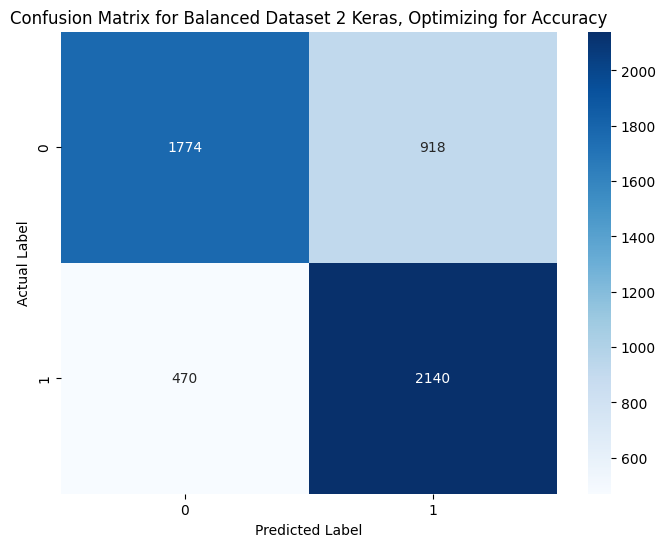

accuracy: 0.7382119954734062
recall: [0.6589896  0.81992337]


In [219]:
y_prob = model_bal2.predict(X_test_bal2) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_bal2, 
                      y_classes, 
                      labels=[0, 1], 
                      title='Confusion Matrix for Balanced Dataset 2 Keras, Optimizing for Accuracy',
                      save_path='confusion_matrix_keras_balanced_accuracy.png')


In [201]:
# optimizing for recall
y_train_p = keras.utils.to_categorical(y_train_bal2, num_classes=2)
y_test_p = keras.utils.to_categorical(y_test_bal2, num_classes=2)

model_bal2 = keras.Sequential([
    Dense(8, activation='relu', input_shape=(22,)),
    Dense(2, activation='softmax'),
])

model_bal2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['recall'])

model_bal2.fit(X_train_bal2, y_train_p, epochs=5, batch_size=32, verbose=1)
loss, accuracy = model_bal2.evaluate(X_test_bal2, y_test_p)
print(f'accuracy: {accuracy}')

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.6999 - recall: 0.5438
Epoch 2/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.5680 - recall: 0.7158
Epoch 3/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.5466 - recall: 0.7283
Epoch 4/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.5291 - recall: 0.7415
Epoch 5/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.5291 - recall: 0.7357
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.5295 - recall: 0.7401
accuracy: 0.7376461625099182


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


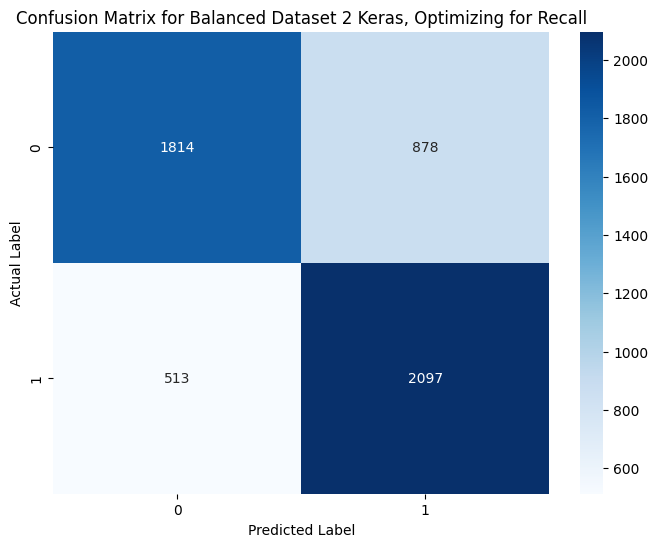

accuracy: 0.7376461712561297
recall: [0.67384844 0.80344828]


In [202]:
y_prob = model_bal2.predict(X_test_bal2) 
y_classes = y_prob.argmax(axis=-1)
plot_confusion_matrix(y_test_bal2, 
                      y_classes, 
                      labels=[0, 1], 
                      title='Confusion Matrix for Balanced Dataset 2 Keras, Optimizing for Recall',
                      save_path='confusion_matrix_keras_balanced_recall.png')


## Scale to larger dataset

I feel like none of the models performed spectacularly, so it doesn't make sense to scale them up, expecially since this data is NOT at all balanced. I just did it here as an example kind of.

---
**Accuracy: 0.8468345999717712**

model = keras.Sequential([
    Dense(5, activation='relu', input_shape=(22,)),
    Dropout(0.2),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_big, y_train_p, epochs=4, batch_size=50, verbose=1)

---

In [203]:
y_train_p = keras.utils.to_categorical(y_train_big, num_classes=3)
y_test_p = keras.utils.to_categorical(y_test_big, num_classes=3)

model = keras.Sequential([
    Dense(5, activation='relu', input_shape=(22,)),
    Dropout(0.2),
    Dense(3, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_big, y_train_p, epochs=4, batch_size=50, verbose=1)
loss, accuracy = model.evaluate(X_test_big, y_test_p)
# predictions = model.predict(new_data)
accuracy

Epoch 1/4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3806/3806 ━━━━━━━━━━━━━━━━━━━━ 5s 911us/step - accuracy: 0.7652 - loss: 0.6409
Epoch 2/4
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 4s 923us/step - accuracy: 0.8450 - loss: 0.4251
Epoch 3/4
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 3s 883us/step - accuracy: 0.8462 - loss: 0.4158
Epoch 4/4
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 3s 869us/step - accuracy: 0.8448 - loss: 0.4153
1982/1982 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.8443 - loss: 0.4008


0.8456165194511414

In [204]:
y_prob = model.predict(X_test_big) 
y_classes = y_prob.argmax(axis=-1)

1982/1982 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step


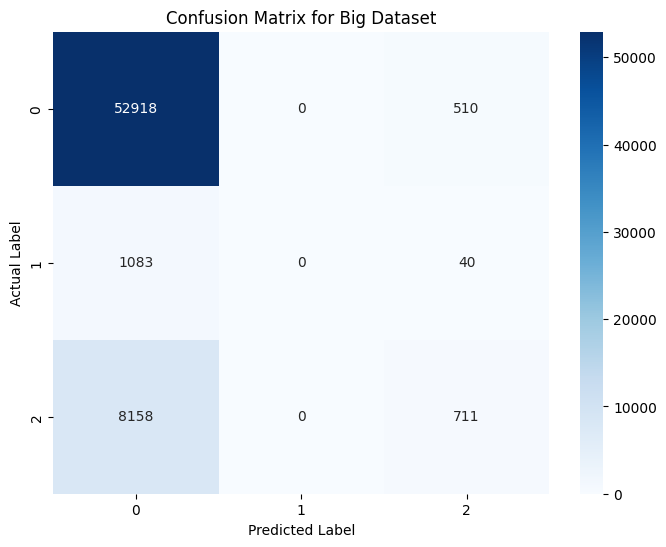

accuracy: 0.8456165247555976
recall: [0.99045444 0.         0.08016687]


'\nSo basically, we do not correctly predict the pre-diabetes class at all.\n- The model predicts most of the pre-diabetes class as no diabetes.\nThe model is also really bad at predicting diabetes. which is obviously worse\n'

In [205]:
plot_confusion_matrix(y_test_big, 
                      y_classes, 
                      labels=[0, 1, 2], 
                      title='Confusion Matrix for Big Dataset', 
                      save_path='df_big_keras_confusion_matrix.png')

'''
So basically, we do not correctly predict the pre-diabetes class at all.
- The model predicts most of the pre-diabetes class as no diabetes.
The model is also really bad at predicting diabetes. which is obviously worse
'''

# Most important features

Plan:
1. use RFC to get important features -- only for the bal2 and bal3 datasets.
2. see if the accuracy or recall improves by using only the important features

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### BAL3

In [207]:
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train_bal3, y_train_bal3)

# Make predictions on the test set
y_pred = clf.predict(X_test_bal3)

# Evaluate the classifier
accuracy = accuracy_score(y_test_bal3, y_pred)
print(f"Accuracy: {accuracy}")

confusion_matrix(y_test_bal3, y_pred)

Accuracy: 0.5025906735751295


array([[718, 238, 215],
       [262, 428, 451],
       [193, 369, 600]])

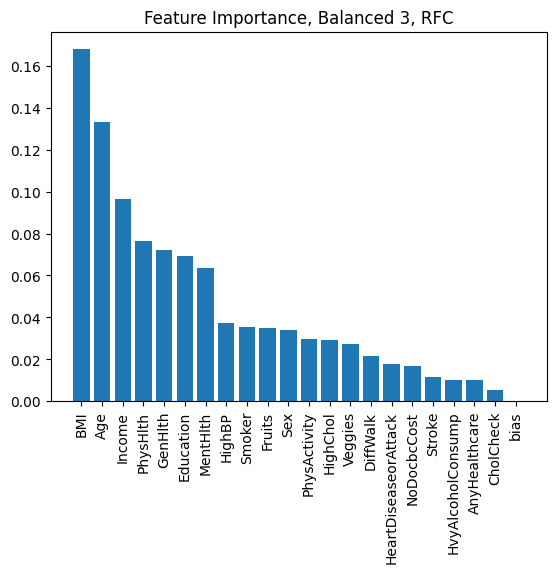

In [208]:
# sort the features
features = df.columns[1:].append(pd.Index(['bias']))

zipped_lists = zip(clf.feature_importances_, features)
sorted_list_df_bal3 = sorted(zipped_lists, reverse=True)
bal3_feat_importance, bal3_feat = zip(*sorted_list_df_bal3)


plt.bar(bal3_feat, bal3_feat_importance)
plt.xticks(rotation=90)
plt.title("Feature Importance, Balanced 3, RFC")

plt.savefig("feature_importance_bal3.png")

plt.show()

In [1]:
plot_confusion_matrix(y_test_bal3, y_pred, labels=[0, 1, 2], title='Confusion Matrix for Balanced Dataset 3, RFC', save_path='confusion_matrix_rfc_bal3.png')

NameError: name 'plot_confusion_matrix' is not defined

## BAL2

In [210]:
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train_bal2, y_train_bal2)

# Make predictions on the test set
y_pred = clf.predict(X_test_bal2)

# Evaluate the classifier
accuracy = accuracy_score(y_test_bal2, y_pred)
print(f"Accuracy: {accuracy}")

confusion_matrix(y_test_bal2, y_pred)

Accuracy: 0.7348170501697473


array([[1840,  852],
       [ 554, 2056]])

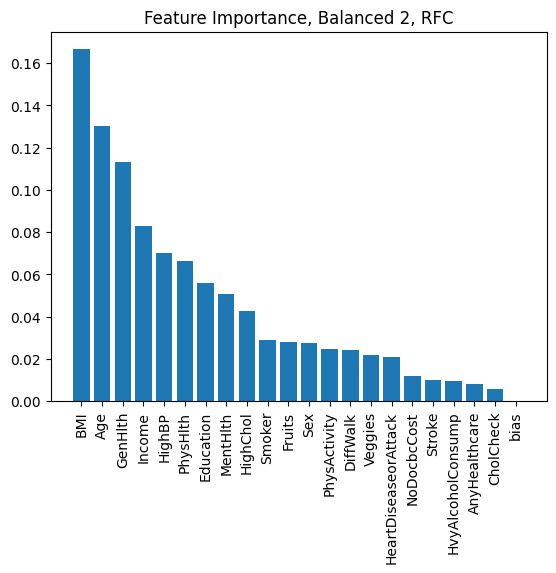

In [211]:
# sort the features
features = df.columns[1:].append(pd.Index(['bias']))
zipped_lists = zip(clf.feature_importances_, features)
sorted_list_df_bal2 = sorted(zipped_lists, reverse=True)
bal2_feat_importance, bal2_feat = zip(*sorted_list_df_bal2)

# plot
plt.bar(bal2_feat, bal2_feat_importance)
plt.xticks(rotation=90)
plt.title("Feature Importance, Balanced 2, RFC")
plt.savefig("feature_importance_bal2.png")
plt.show()

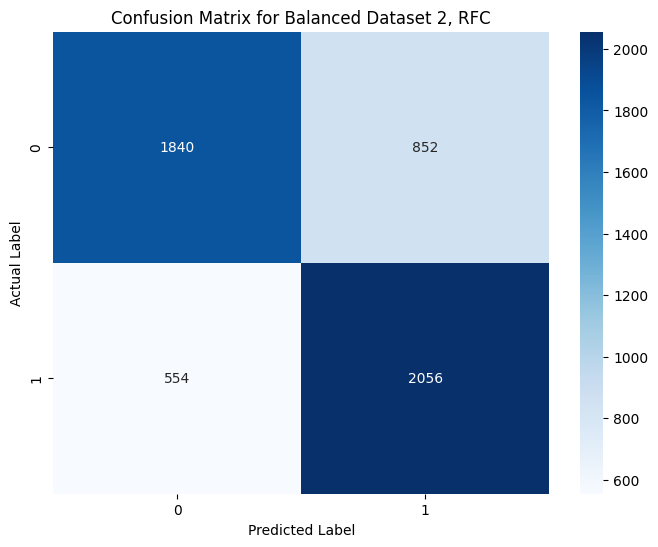

accuracy: 0.7348170501697473
recall: [0.68350669 0.78773946]


In [212]:
plot_confusion_matrix(
    y_test_bal2, 
    y_pred, labels=[0, 1], 
    title='Confusion Matrix for Balanced Dataset 2, RFC', 
    save_path='confusion_matrix_rfc_bal2.png')

## Create subset data

In [213]:
# Create new data subset
important_feats_bal3 = bal3_feat[:10] + ('Diabetes_012',)
important_feats_bal2 = bal2_feat[:10] + ('Diabetes_binary',)

df_bal3_important_feats = df_balanced3[list(important_feats_bal3)]
X_train_bal3_if, X_test_bal3_if, y_train_bal3_if, y_test_bal3_if = getTrainTestData(df_bal3_important_feats, 'Diabetes_012')

df_bal2_important_feats = df_balanced2[list(important_feats_bal2)]
X_train_bal2_if, X_test_bal2_if, y_train_bal2_if, y_test_bal2_if = getTrainTestData(df_bal2_important_feats, 'Diabetes_binary')

0.5031663788140472


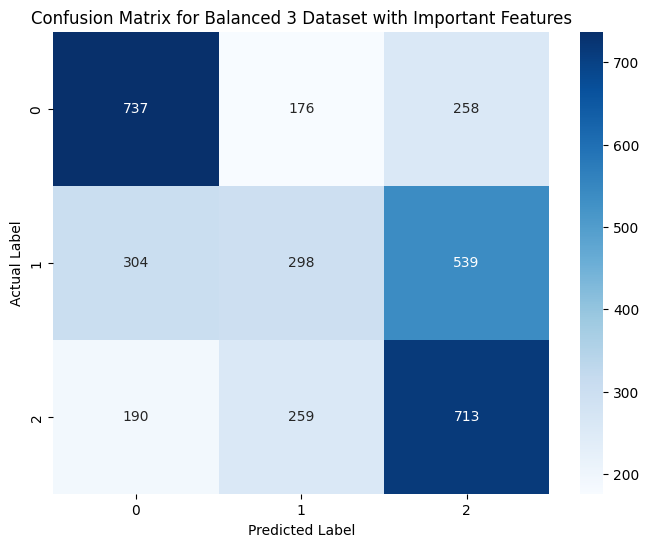

accuracy: 0.5031663788140472
recall: [0.6293766  0.26117441 0.61359725]


In [214]:
# Test MLP on df_small filtered on imporant features
mlp_bal3_if = MLPClassifier(
    random_state=1, 
    max_iter=300,
    batch_size=50,
    hidden_layer_sizes=(8),
    learning_rate='invscaling',
                    ).fit(X_train_bal3_if, y_train_bal3_if)

print(mlp_bal3_if.score(X_test_bal3_if, y_test_bal3_if))

plot_confusion_matrix(
    y_test_bal3_if,
    mlp_bal3_if.predict(X_test_bal3_if),
    labels=[0, 1, 2],
    title='Confusion Matrix for Balanced 3 Dataset with Important Features',
    save_path='confusion_matrix_if_bal3.png'
)

0.7402866842700868


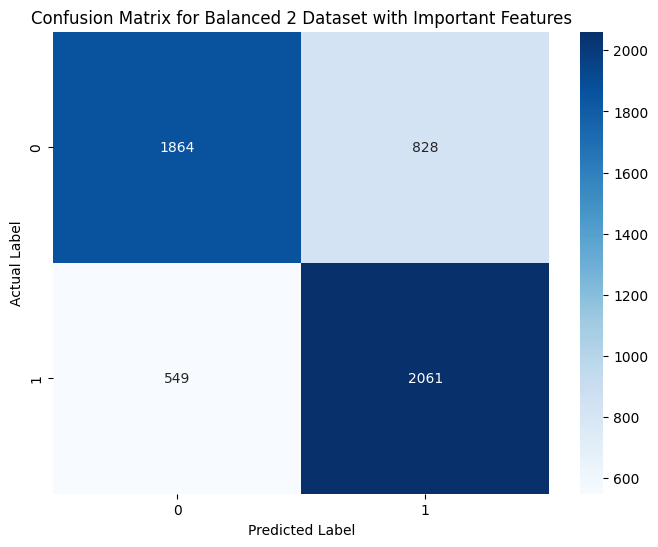

accuracy: 0.7402866842700868
recall: [0.69242199 0.78965517]


In [215]:
# Test MLP on df_balanced filtered on imporant features
mlp_bal2_if = MLPClassifier(
    random_state=1, 
    max_iter=300,
    batch_size=100,
    hidden_layer_sizes=(5),
    learning_rate='invscaling',
                    ).fit(X_train_bal2_if, y_train_bal2_if)

print(mlp_bal2_if.score(X_test_bal2_if, y_test_bal2_if))

plot_confusion_matrix(
    y_test_bal2_if,
    mlp_bal2_if.predict(X_test_bal2_if),
    labels=[0, 1],
    title='Confusion Matrix for Balanced 2 Dataset with Important Features',
    save_path='confusion_matrix_if_bal2.png'
)